In [1]:
import sys, pdb
from importlib import reload
from astropy import units as un, constants as cons
from astropy.cosmology import Planck15 as cosmo
import numpy as np
from numpy import log10 as log
sys.path.append('../pysrc/')
import GIZMO_ICs as ics

In [2]:
import warnings
warnings.filterwarnings('ignore')

# example 

In [3]:
#set CGM parameters
Rcirc = 10*un.kpc
vc = 200*un.km/un.s
Rsonic = 0.1*un.kpc
resolution = 1e5*un.Msun #for example, resolution is set to be exceptionally low
Z_CGM = 0.3
fiducial = ics.ICs(vc=vc,Rcirc=Rcirc,Rsonic=Rsonic, resolution = resolution,Z_CGM=Z_CGM)

In [4]:
fiducial.calc_CF_solution(pr=True)
ind = (fiducial.CF_solution.Rs()>20*un.kpc).nonzero()[0][0]
log_nH = log(fiducial.CF_solution.nHs()[ind].value)
print('log nH(20 kpc)=%.2f, Mdot=%.3f'%(log_nH,fiducial.CF_solution.Mdot.value))

Integrated with v_c^2/c_s^2 (R_sonic) =1.000010;  maximum r=3 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.500005;  no transsonic solutions
Integrated with v_c^2/c_s^2 (R_sonic) =1.250008;  maximum r=1 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.125009;  maximum r=22 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.187508;  maximum r=34 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.156258;  maximum r=84 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.171883;  maximum r=743 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.179696;  maximum r=156 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.175789;  maximum r=941 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.173836;  maximum r=2571 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.174813;  maximum r=2482 kpc; stop reason: sonic point
Integrated 

In [5]:
fiducial.create_output_files()

files saved to: ../ICs/vc200_Rs0_Mdot1035_Rcirc10_res1e5
 2r(t_cool=10Gyr) = 126 kpc, r(t_sc=20Gyr) = 3227 kpc
Part0 num=313124, |<r>|=0.2, |<v>|=0.1, <j>=1.3 0.3 1327.7,Ms: 1e+05 3e+05 9e+05... 6e+09


# verification: plot integrated 1D solution

In [6]:
import pylab as pl
import matplotlib
import my_utils as u
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rc('font', family='serif', size=10)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
fig_width_half = 3.4

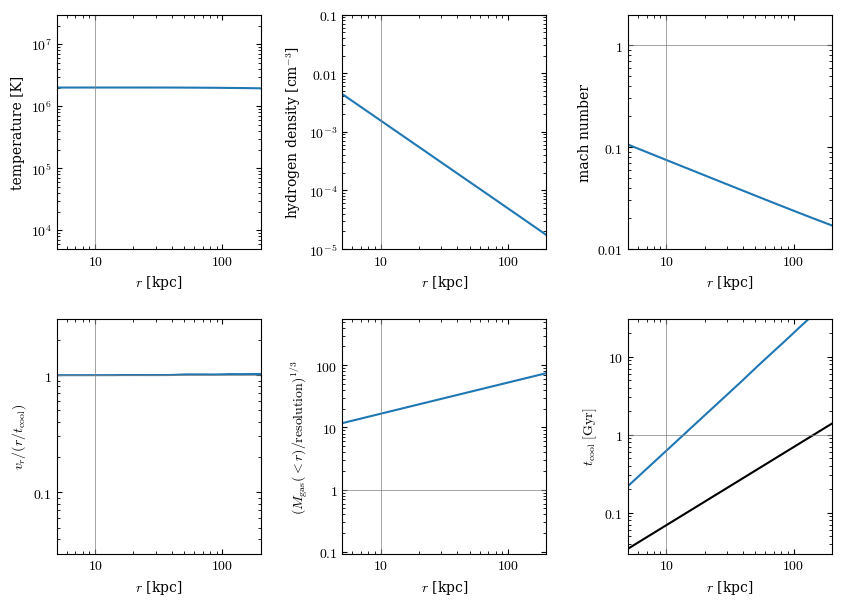

In [7]:
fig = pl.figure(figsize=(10,7))
pl.subplots_adjust(hspace=0.3,wspace=0.4)
for iPanel in range(6):
    ax = pl.subplot(2,3,iPanel+1)
    for sol in [fiducial]:
        res = sol.CF_solution
        if iPanel==0: ys = res.Ts()
        if iPanel==1: ys = res.nHs()
        if iPanel==2: ys = res.Ms()
        if iPanel==3: ys = (res.t_cools() / (res.Rs()/res.vrs())).to('')
        if iPanel==4: ys = (res.Mgas()/sol.resolution)**(1/3.)
        if iPanel==5: ys = res.t_cools() 
        pl.loglog(res.Rs(),ys)
    pl.xlim(5,200)
    pl.xlabel(r'$r$ [kpc]')
    pl.axvline(Rcirc.value,c='.5',lw=0.5)
    ax.xaxis.set_major_formatter(u.arilogformatter)
    ax.yaxis.set_major_formatter(u.arilogformatter)
    if iPanel==0:
        pl.ylabel(r'temperature [K]')
        pl.ylim(0.5e4,3e7)
    if iPanel==1: 
        pl.ylabel(r'hydrogen density [cm$^{-3}$]')
        pl.ylim(1e-5,0.1)
    if iPanel==2: 
        pl.ylabel(r'mach number')
        pl.ylim(0.01,2)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==3: 
        pl.ylabel(r'$v_r / (r/t_{\rm cool})$')
        pl.ylim(0.03,3)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==4:
        pl.ylabel(r'$(M_{\rm gas}(<r) / {\rm resolution})^{1/3}$')
#         pl.ylim(0.03,3)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==5: 
        pl.plot(res.Rs(),res.tff().to('Gyr'),c='k')
        pl.ylabel(r'$t_{\rm cool}\ [{\rm Gyr}]$')
        pl.ylim(0.03,30)
        pl.axhline(1.,c='.5',lw=0.5)

# verification: plot ICs snapshot 

In [8]:
import h5py, scipy, scipy.stats, pylab as pl
from astropy import units as un, constants as cons
%matplotlib inline
instance = fiducial
init_snapshot_fn = instance.outdirname()+'/init_snapshot.hdf5'
init_snapshot = h5py.File(init_snapshot_fn,'r')

In [9]:
coords = init_snapshot['PartType0']['Coordinates']
vels = init_snapshot['PartType0']['Velocities']
inds = (coords[:,1]<5) & (coords[:,1]>-5)
Xs = coords[:,0][inds]
Zs = coords[:,2][inds]
phis = np.arctan2(vels[:,1][inds],vels[:,0][inds])

In [10]:
bins = (np.arange(-50,50,5),np.arange(-50,50,5))
m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                         Zs,
                                         vels[:,1][inds],
                                         statistic='median',
                                         bins=bins)
x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

Text(0, 0.5, 'z [kpc]')

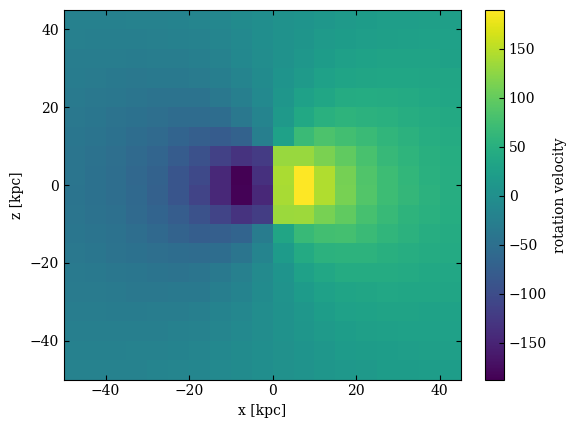

In [11]:
pl.pcolormesh(x,y,m.T)
pl.colorbar(label = r'rotation velocity')
pl.xlabel('x [kpc]'); pl.ylabel('z [kpc]')